In [1]:
# 실행결과 모두 보기
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [ ]:
# Full screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [ ]:
# 가로에 모든 결과 화면 보이기
CSS = """.output {flex-direction: row;}"""
HTML('<style>{}</style>'.format(CSS))

In [ ]:
!pip install selenium
!apt-get update
!apt install chromium-chromedriver

In [1]:
# 데이터 크롤링 모듈
from selenium import webdriver
from bs4 import BeautifulSoup
import re

In [2]:
# 데이터 분석 모듈
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime
from string import ascii_lowercase
from itertools import combinations

import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import  GradientBoostingClassifier
import numpy as np
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.metrics import classification_report

In [3]:
# 가상 웹드라이버 불러오기
# chromedriver.exe가 크롬 버젼에 맞게 설치 되어 있어야 함
#driver = webdriver.Chrome('webdrivers/chromedriver.exe')
driver = webdriver.Chrome('C:\selenium\chromedriver.exe')
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome('chromedriver', chrome_options=chrome_options)


<ipython-input-3-8e8691e1ecd3>:4: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('C:\selenium\chromedriver.exe')
<ipython-input-3-8e8691e1ecd3>:9: DeprecationWarning: use options instead of chrome_options
  driver = webdriver.Chrome('chromedriver', chrome_options=chrome_options)


WebDriverException: Message: 'chromedriver' executable needs to be in PATH. Please see https://chromedriver.chromium.org/home


# 스탯티즈 타자 기록 크롤링

In [12]:
# 크롤링
for i in range(13):
    
    # 2016년 부터 2021년 까지 statiz에 1군 타석 기록(30타수 이상) (총 1209건) 
    #url ='http://www.statiz.co.kr/stat.php?mid=stat&re=0&ys=2016&ye=2021&se=0&te=&tm=&ty=0&qu=auto&po=0&as=&ae=&hi=&un=&pl=&da=1&o1=WAR_ALL_ADJ&o2=TPA&de=1&lr=0&tr=&cv=&ml=2&sn=100&pa={}&si=&cn='.format(i*100)
    url ='http://www.statiz.co.kr/stat.php?mid=stat&re=0&ys=2016&ye=2021&se=0&te=&tm=&ty=0&qu=auto&po=0&as=&ae=&hi=&un=&pl=&da=1&o1=WAR_ALL_ADJ&o2=TPA&de=1&lr=0&tr=&cv=&ml=2&sn=100&pa={}&si=&cn=AB,30,0,RBI,,0'.format(i*100)
    driver.get(url)
    driver.implicitly_wait(5)
    
    html = driver.find_element_by_xpath('//*[@id="mytable"]/tbody').get_attribute("innerHTML") #기록 table을 str형태로 저장
    soup = BeautifulSoup(html, 'html.parser') #str 객체를 BeautifulSoup 객체로 변경
    
    temp = [i.text.strip() for i in soup.findAll("tr")] #tr 태그에서, text만 저장하기
    temp = pd.Series(temp) #list 객체에서 series 객체로 변경
    
    #'순'이나 'W'로 시작하는 row 제거
    # 즉, 선수별 기록만 남기고, index를 reset 해주기
    temp = temp[~temp.str.match("[순W]")].reset_index(drop=True) 
    
    temp = temp.apply(lambda x: pd.Series(x.split(' '))) #띄어쓰기 기준으로 나눠서 dataframe으로 변경
    
    #선수 팀 정보 이후 첫번째 기록과는 space 하나로 구분, 그 이후로는 space 두개로 구분이 되어 있음 
    #그래서 space 하나로 구분을 시키면, 빈 column들이 존재 하는데, 해당 column들 제거 
    temp = temp.replace('', np.nan).dropna(axis=1) 
    
    #WAR 정보가 들어간 column이 2개 있다. (index가 1인 column과, 제일 마지막 column)
    #그 중에서 index가 1인 columm 제거 
    temp = temp.drop(1, axis=1)
    
    #선수 이름 앞의 숫자 제거
    temp[0] = temp[0].str.replace("^\d+", '')

    # 선수들의 생일 정보가 담긴 tag들 가지고 오기
    birth = [i.find("a") for i in soup.findAll('tr') if 'birth' in i.find('a').attrs['href']]
    
    # tag내에서, 생일 날짜만 추출하기 
    p = re.compile("\d{4}\-\d{2}\-\d{2}")
    birth = [p.findall(i.attrs['href'])[0] for i in birth]
    
    # 생일 column 추가
    temp['생일'] = birth
    
    # page별 완성된 dataframe을 계속해서 result에 추가 시켜주기 
    if i == 0:
        result = temp
    else:
        result = result.append(temp)
        result = result.reset_index(drop=True)
        
    print(i, "완료")
        
#column 명 정보 저장        
columns = ['선수'] + [i.text for i in soup.findAll("tr")[0].findAll("th")][4:-3] + ['타율', '출루', '장타', 'OPS', 'wOBA', 'wRC+', 'WAR+','WPA','생일']

#column 명 추가
result.columns = columns

#webdriver 종료
driver.close()

print("최종 완료")

<ipython-input-12-21c002a8a60b>:10: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  html = driver.find_element_by_xpath('//*[@id="mytable"]/tbody').get_attribute("innerHTML") #기록 table을 str형태로 저장


0 완료


<ipython-input-12-21c002a8a60b>:10: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  html = driver.find_element_by_xpath('//*[@id="mytable"]/tbody').get_attribute("innerHTML") #기록 table을 str형태로 저장


1 완료


<ipython-input-12-21c002a8a60b>:10: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  html = driver.find_element_by_xpath('//*[@id="mytable"]/tbody').get_attribute("innerHTML") #기록 table을 str형태로 저장


2 완료


<ipython-input-12-21c002a8a60b>:10: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  html = driver.find_element_by_xpath('//*[@id="mytable"]/tbody').get_attribute("innerHTML") #기록 table을 str형태로 저장


3 완료


<ipython-input-12-21c002a8a60b>:10: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  html = driver.find_element_by_xpath('//*[@id="mytable"]/tbody').get_attribute("innerHTML") #기록 table을 str형태로 저장


4 완료


<ipython-input-12-21c002a8a60b>:10: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  html = driver.find_element_by_xpath('//*[@id="mytable"]/tbody').get_attribute("innerHTML") #기록 table을 str형태로 저장


5 완료


<ipython-input-12-21c002a8a60b>:10: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  html = driver.find_element_by_xpath('//*[@id="mytable"]/tbody').get_attribute("innerHTML") #기록 table을 str형태로 저장


6 완료


<ipython-input-12-21c002a8a60b>:10: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  html = driver.find_element_by_xpath('//*[@id="mytable"]/tbody').get_attribute("innerHTML") #기록 table을 str형태로 저장


7 완료


<ipython-input-12-21c002a8a60b>:10: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  html = driver.find_element_by_xpath('//*[@id="mytable"]/tbody').get_attribute("innerHTML") #기록 table을 str형태로 저장


8 완료


<ipython-input-12-21c002a8a60b>:10: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  html = driver.find_element_by_xpath('//*[@id="mytable"]/tbody').get_attribute("innerHTML") #기록 table을 str형태로 저장


9 완료


<ipython-input-12-21c002a8a60b>:10: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  html = driver.find_element_by_xpath('//*[@id="mytable"]/tbody').get_attribute("innerHTML") #기록 table을 str형태로 저장


10 완료


<ipython-input-12-21c002a8a60b>:10: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  html = driver.find_element_by_xpath('//*[@id="mytable"]/tbody').get_attribute("innerHTML") #기록 table을 str형태로 저장


11 완료


<ipython-input-12-21c002a8a60b>:10: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  html = driver.find_element_by_xpath('//*[@id="mytable"]/tbody').get_attribute("innerHTML") #기록 table을 str형태로 저장


12 완료
최종 완료


In [13]:
#결과값 저장 (구글드라이브) -> 로컬에 저장(유호영) 
#result.to_csv("/content/drive/MyDrive/statiz_origin_2016_2021.csv")
result.to_csv("statiz_origin_2016_2021.csv")

In [36]:
# 저장해둔 데이터 불러오기
result = pd.read_csv("statiz_origin_2016_2021.csv", index_col=0)

In [37]:
# 이름 분리 해서, '이름' column 추가
result['이름'] = result['선수'].str.findall("^[ㄱ-힣]+").apply(lambda x: x[0])

# 기존 '선수' column 에 있던 이름 정보 제거
result['선수'] = result.apply(lambda x: x['선수'].replace(x['이름'], ''), axis=1)

# '시즌' column 생성
result['시즌'] = result['선수'].apply(lambda x: x[:2])

# 기존 '선수' column 에 있던 시즌 정보 제거
result['선수'] = result.apply(lambda x: x['선수'].replace(x['시즌'],''), axis=1)

# 년도를 4자리 숫자로 바꾸어주기 ex) 98 -&gt; 1998, 15 -&gt; 2015
result['시즌'] = result['시즌'].apply(lambda x: int("20"+x))

In [38]:
# 포지션
position = ['1B', '2B', '3B', 'SS', 'C', 'RF', 'LF', 'CF', 'DH'] 

# 포지션 여부 확인
result['포지션여부'] = result['선수'].apply(lambda x : (np.isin(x[-2:], position) or np.isin(x[-1:], position))) 

# 포지션 분리
result['포지션'] = result['선수'].apply(lambda x: x[-2:] if x[-2:] in position else x[-1:])

#포지션이 기록 되어 있지 않으면, nan값 넣기 
result.loc[result['포지션여부']==False, '포지션'] = np.nan

In [39]:
# 팀 & 나이 column 생성
result['팀'] = result.apply(lambda x: x['선수'].replace(x['포지션'],'') if type(x['포지션'])==str else x['선수'], axis=1)
result['나이'] = result.apply(lambda x: x['시즌'] - int(x['생일'][:4]) + 1, axis=1)

In [40]:
# 선수별 고유 아이디 부여
info = result[['이름', '생일']].apply(lambda x: tuple(x), axis=1)

player_id = {}
for i,j in enumerate(info.unique()):
    player_id[j] = i
    
result['ID'] = result.apply(lambda x: player_id[tuple([x['이름'], x['생일']])], axis=1)

In [41]:
result = result.drop('선수', axis=1)

In [42]:
df_record = result.reindex(columns=['ID','이름','시즌','팀','생일','나이','포지션','포지션여부','G','타수','득점','안타','2타','3타','홈런',	'루타',	'타점',	'도루',	'도실',	'볼넷',	'사구',	'고4',	'삼진',	'병살',	'희타',	'희비',	'타율',	'출루','장타',	'OPS',	'wOBA',	'wRC+',	'WAR+',	'WPA'])

In [43]:
df_record['팀'].unique()
df_record['포지션'].unique()
df_record['시즌'].unique()

array([2016, 2020, 2017, 2019, 2021, 2018], dtype=int64)

In [44]:
df_record.head()

,ID,이름,시즌,팀,생일,나이,포지션,포지션여부,G,타수,...,희타,희비,타율,출루,장타,OPS,wOBA,wRC+,WAR+,WPA
0,0,최형우,2016,삼,1983-12-16,34,LF,True,138,519,...,0,7,0.376,0.464,0.651,1.116,0.480,177.8,7.75,5.50
1,1,로하스,2020,K,1990-05-24,31,RF,True,140,542,...,0,8,0.349,0.416,0.679,1.095,0.466,180.3,7.62,7.22
2,2,김재환,2017,두,1988-09-22,30,LF,True,144,544,...,0,4,0.340,0.429,0.603,1.032,0.440,170.9,7.46,7.45
3,3,김하성,2019,키,1995-10-17,25,SS,True,139,540,...,1,7,0.307,0.389,0.491,0.880,0.397,145.7,7.17,4.52
4,4,박건우,2017,두,1990-09-08,28,CF,True,131,483,...,5,4,0.366,0.424,0.582,1.006,0.433,163.8,7.01,2.76


In [45]:
#컬럼 형변환
df_record['ID'] = df_record['ID'].astype(str)

In [46]:
df_record.info()
df_record.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1209 entries, 0 to 1208
Data columns (total 34 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      1209 non-null   object 
 1   이름      1209 non-null   object 
 2   시즌      1209 non-null   int64  
 3   팀       1209 non-null   object 
 4   생일      1209 non-null   object 
 5   나이      1209 non-null   int64  
 6   포지션     1203 non-null   object 
 7   포지션여부   1209 non-null   bool   
 8   G       1209 non-null   int64  
 9   타수      1209 non-null   int64  
 10  득점      1209 non-null   int64  
 11  안타      1209 non-null   int64  
 12  2타      1209 non-null   int64  
 13  3타      1209 non-null   int64  
 14  홈런      1209 non-null   int64  
 15  루타      1209 non-null   int64  
 16  타점      1209 non-null   int64  
 17  도루      1209 non-null   int64  
 18  도실      1209 non-null   int64  
 19  볼넷      1209 non-null   int64  
 20  사구      1209 non-null   int64  
 21  고4      1209 non-null   int64  
 22  

,시즌,나이,G,타수,득점,안타,2타,3타,홈런,루타,...,희타,희비,타율,출루,장타,OPS,wOBA,wRC+,WAR+,WPA
count,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,...,1209.000000,1209.000000,1209.00000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000
mean,2018.555004,30.076923,85.813069,241.915633,36.080232,67.428453,11.838710,1.000827,6.833747,101.770058,...,2.498759,2.332506,0.25699,0.329491,0.377668,0.707139,0.321063,84.089165,1.095112,0.415012
std,1.719722,4.683160,39.628299,167.445873,29.433239,53.104094,10.374987,1.690203,8.685433,85.148478,...,3.097244,2.531970,0.05130,0.055869,0.102781,0.148989,0.060029,39.547003,1.708222,1.544662
min,2016.000000,19.000000,10.000000,30.000000,0.000000,3.000000,0.000000,0.000000,0.000000,3.000000,...,0.000000,0.000000,0.08100,0.117000,0.081000,0.234000,0.116000,-48.200000,-1.710000,-2.740000
25%,2017.000000,27.000000,52.000000,84.000000,11.000000,20.000000,3.000000,0.000000,1.000000,27.000000,...,0.000000,0.000000,0.22700,0.297000,0.305000,0.611000,0.284000,59.700000,-0.100000,-0.500000
50%,2019.000000,30.000000,89.000000,200.000000,27.000000,52.000000,9.000000,0.000000,3.000000,74.000000,...,1.000000,1.000000,0.26200,0.333000,0.374000,0.709000,0.324000,86.500000,0.440000,-0.020000
75%,2020.000000,33.000000,122.000000,399.000000,55.000000,112.000000,19.000000,1.000000,9.000000,166.000000,...,4.000000,3.000000,0.29200,0.368000,0.443000,0.807000,0.363000,111.300000,1.930000,0.910000
max,2021.000000,42.000000,144.000000,600.000000,121.000000,197.000000,48.000000,13.000000,46.000000,368.000000,...,22.000000,13.000000,0.42400,0.525000,0.767000,1.192000,0.512000,208.200000,7.750000,7.450000


In [47]:
df_record['ID'][df_record['타수']<30].count()

0

# 2.스탯티즈에서 기록 데이터에 있는 선수들의 연봉 크롤링

In [ ]:
# 가상 웹드라이버 불러오기
# chromedriver.exe가 크롬 버젼에 맞게 설치 되어 있어야 함
#driver = webdriver.Chrome('webdrivers/chromedriver.exe')
driver = webdriver.Chrome('C:\selenium\chromedriver.exe')
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome('chromedriver', chrome_options=chrome_options)


In [ ]:
df_temp=df_record[['이름','생일']]
df_temp=df_temp.drop_duplicates()
df_temp=df_temp.reset_index(drop=True)

# 크롤링
for i in range(len(df_temp)):
    
  # 기록 데이터 프레임으로 연도별 연봉 크롤링(2912건)
  url=('http://www.statiz.co.kr/player.php?opt=11&name='+df_temp.loc[i]['이름']+'&birth='+df_temp.loc[i]['생일']).format(i)
  driver.get(url)
  driver.implicitly_wait(5)

  html = driver.find_element_by_xpath('//*[@class="table table-striped table-condensed"]/tbody').get_attribute("innerHTML") #기록 table을 str형태로 저장
  soup = BeautifulSoup(html, 'html.parser') #str 객체를 BeautifulSoup 객체로 변경

  temp =[i.text.strip() for i in soup.findAll("td")]  #td 태그에서, text만 저장하기
  result=pd.DataFrame(np.array(temp).reshape(len(temp)//3,3))
  result['이름']=df_temp.loc[i]['이름']
  result['생일']=df_temp.loc[i]['생일']

  # page별 완성된 dataframe을 계속해서 result에 추가 시켜주기 
  if i == 0:
      df_salary = result
  else:
      df_salary = df_salary.append(result)
      df_salary = df_salary.reset_index(drop=True)        
  print(i, "완료")

#column 명 추가
df_salary.columns=['시즌','연봉','WAR','이름','생일']

#webdriver 종료
driver.close()

print("최종 완료")

In [ ]:
#결과값 저장 (구글드라이브)
#df_salary.to_csv("/content/drive/MyDrive/statiz_salary.csv")
#로컬에 저장 (유호영)
df_salary.to_csv("statiz_salary.csv")

In [48]:
# 저장해둔 연봉 데이터 불러오기
#df_salary = pd.read_csv("/content/drive/MyDrive/statiz_salary.csv", index_col=0)
df_salary = pd.read_csv("statiz_salary.csv", index_col=0)

In [49]:
df_salary.head(20)

,시즌,연봉,WAR,이름,생일
0,2014,"25,000",6.141,테임즈,1986-11-10
1,2015,"125,000",10.873,테임즈,1986-11-10
2,2016,"125,000",5.677,테임즈,1986-11-10
3,2006,NaN,-0.231,강정호,1987-04-05
4,2007,"2,000",-0.172,강정호,1987-04-05
5,2008,"2,000",2.410,강정호,1987-04-05
6,2009,"4,400",3.980,강정호,1987-04-05
7,2010,"4,400",4.791,강정호,1987-04-05
8,2011,"16,000",3.426,강정호,1987-04-05
9,2012,"18,000",8.234,강정호,1987-04-05


In [50]:
df_salary.info()
df_salary.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3227 entries, 0 to 3226
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   시즌      3227 non-null   int64  
 1   연봉      2911 non-null   object 
 2   WAR     3227 non-null   float64
 3   이름      3227 non-null   object 
 4   생일      3227 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 151.3+ KB


시즌       0
연봉     316
WAR      0
이름       0
생일       0
dtype: int64

In [51]:
df_record.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1209 entries, 0 to 1208
Data columns (total 34 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      1209 non-null   object 
 1   이름      1209 non-null   object 
 2   시즌      1209 non-null   int64  
 3   팀       1209 non-null   object 
 4   생일      1209 non-null   object 
 5   나이      1209 non-null   int64  
 6   포지션     1203 non-null   object 
 7   포지션여부   1209 non-null   bool   
 8   G       1209 non-null   int64  
 9   타수      1209 non-null   int64  
 10  득점      1209 non-null   int64  
 11  안타      1209 non-null   int64  
 12  2타      1209 non-null   int64  
 13  3타      1209 non-null   int64  
 14  홈런      1209 non-null   int64  
 15  루타      1209 non-null   int64  
 16  타점      1209 non-null   int64  
 17  도루      1209 non-null   int64  
 18  도실      1209 non-null   int64  
 19  볼넷      1209 non-null   int64  
 20  사구      1209 non-null   int64  
 21  고4      1209 non-null   int64  
 22  

In [52]:
#기록 데이터프레임과 join을 위해 연봉 기준 기록인 전 시즌으로 조정
df_salary['시즌']=df_salary['시즌']-1

In [53]:
df_salary['시즌'].unique()

array([2013, 2014, 2015, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2004, 2017, 2018, 2019, 2020, 2001, 2003, 2016, 2000, 2002, 1999,
       1998, 1994, 1995, 1996, 1997, 1993], dtype=int64)

In [32]:
# 개명 선수 이름 변경
#df_salary['이름'] = df_salary['이름'].replace("한동민", "한유섬")

In [54]:
df_salary = df_salary.drop(['WAR'], axis=1)
#불필요 컬럼 WAR drop

In [55]:
#record 데이터가 2016년 부터였으므로 2016 이후 데이터만
df_salary = df_salary[df_salary['시즌'] >= 2016].reset_index(drop=True)

In [56]:
df_salary.head()
df_salary.tail()
df_salary['시즌'].unique()

array([2017, 2018, 2019, 2020, 2016], dtype=int64)

In [57]:
#이름,생일과 시즌으로 데이터프레임 JOIN
df_merge=pd.merge(df_record, df_salary ,on=['이름','생일','시즌'], how="inner") 

In [58]:
len(df_merge) #df_record 1209, df_salary 2912

823

In [59]:
df_merge

,ID,이름,시즌,팀,생일,나이,포지션,포지션여부,G,타수,...,희비,타율,출루,장타,OPS,wOBA,wRC+,WAR+,WPA,연봉
0,0,최형우,2016,삼,1983-12-16,34,LF,True,138,519,...,7,0.376,0.464,0.651,1.116,0.480,177.8,7.75,5.50,"150,000"
1,2,김재환,2017,두,1988-09-22,30,LF,True,144,544,...,4,0.340,0.429,0.603,1.032,0.440,170.9,7.46,7.45,"47,000"
2,3,김하성,2019,키,1995-10-17,25,SS,True,139,540,...,7,0.307,0.389,0.491,0.880,0.397,145.7,7.17,4.52,"32,000"
3,4,박건우,2017,두,1990-09-08,28,CF,True,131,483,...,4,0.366,0.424,0.582,1.006,0.433,163.8,7.01,2.76,"37,000"
4,2,김재환,2018,두,1988-09-22,31,LF,True,139,527,...,7,0.334,0.405,0.657,1.062,0.438,168.8,6.94,5.80,"47,000"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818,363,정보근,2020,롯,1999-08-31,22,C,True,85,133,...,1,0.150,0.219,0.165,0.385,0.187,-3.9,-1.18,-1.76,"2,900"
819,419,김연훈,2016,k,1984-12-23,33,1B,True,103,166,...,3,0.217,0.244,0.295,0.540,0.237,19.2,-1.20,-0.36,"4,100"
820,174,이해창,2016,k,1987-05-11,30,C,True,88,231,...,3,0.203,0.240,0.325,0.565,0.246,25.1,-1.21,-2.38,"4,500"
821,420,조인성,2016,한,1975-05-25,42,C,True,76,137,...,0,0.168,0.186,0.248,0.434,0.188,-12.4,-1.36,-1.88,"40,000"


In [60]:
df_record[df_record['이름']=='나종덕']
df_salary[df_salary['이름']=='나종덕']

,시즌,연봉,이름,생일
1255,2016,"2,700",나종덕,1998-03-16
1256,2017,"2,800",나종덕,1998-03-16
1257,2018,"2,800",나종덕,1998-03-16


In [61]:
#나종덕 나균안으로 개명하여 크롤링에서 누락됨(이런 건은 계속 보면서 찾아야함)
# 2021년도 연봉 4300만원 강제로 insert 하여 다시 join - 2020년도 연봉은 없네 ;;
new_data = {'시즌':2020,'연봉':'4,300', '이름':'나종덕','생일':'1998-03-16'}
df_salary = df_salary.append(new_data, ignore_index=True)
df_salary.tail()

,시즌,연봉,이름,생일
1254,2020,"3,300",주현상,1992-08-10
1255,2016,"2,700",나종덕,1998-03-16
1256,2017,"2,800",나종덕,1998-03-16
1257,2018,"2,800",나종덕,1998-03-16
1258,2020,"4,300",나종덕,1998-03-16


In [62]:
len(df_merge)
df_merge.isnull().sum()

ID       0
이름       0
시즌       0
팀        0
생일       0
나이       0
포지션      2
포지션여부    0
G        0
타수       0
득점       0
안타       0
2타       0
3타       0
홈런       0
루타       0
타점       0
도루       0
도실       0
볼넷       0
사구       0
고4       0
삼진       0
병살       0
희타       0
희비       0
타율       0
출루       0
장타       0
OPS      0
wOBA     0
wRC+     0
WAR+     0
WPA      0
연봉       5
dtype: int64

In [63]:
# 연봉없는 건 5건 제거
df_merge=df_merge[df_merge['연봉'].notnull()]

In [64]:
#최종 818건으로 조정
len(df_merge)

818

In [65]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 818 entries, 0 to 822
Data columns (total 35 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      818 non-null    object 
 1   이름      818 non-null    object 
 2   시즌      818 non-null    int64  
 3   팀       818 non-null    object 
 4   생일      818 non-null    object 
 5   나이      818 non-null    int64  
 6   포지션     816 non-null    object 
 7   포지션여부   818 non-null    bool   
 8   G       818 non-null    int64  
 9   타수      818 non-null    int64  
 10  득점      818 non-null    int64  
 11  안타      818 non-null    int64  
 12  2타      818 non-null    int64  
 13  3타      818 non-null    int64  
 14  홈런      818 non-null    int64  
 15  루타      818 non-null    int64  
 16  타점      818 non-null    int64  
 17  도루      818 non-null    int64  
 18  도실      818 non-null    int64  
 19  볼넷      818 non-null    int64  
 20  사구      818 non-null    int64  
 21  고4      818 non-null    int64  
 22  삼진

In [66]:
#컬럼 형변환
df_merge['연봉']=df_merge['연봉'].str.replace(',','')

<ipython-input-66-2cd66454e4b3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge['연봉']=df_merge['연봉'].str.replace(',','')


In [67]:
df_merge['연봉']=pd.to_numeric(df_merge['연봉'])

<ipython-input-67-0ab6013f18d4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge['연봉']=pd.to_numeric(df_merge['연봉'])


In [68]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 818 entries, 0 to 822
Data columns (total 35 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      818 non-null    object 
 1   이름      818 non-null    object 
 2   시즌      818 non-null    int64  
 3   팀       818 non-null    object 
 4   생일      818 non-null    object 
 5   나이      818 non-null    int64  
 6   포지션     816 non-null    object 
 7   포지션여부   818 non-null    bool   
 8   G       818 non-null    int64  
 9   타수      818 non-null    int64  
 10  득점      818 non-null    int64  
 11  안타      818 non-null    int64  
 12  2타      818 non-null    int64  
 13  3타      818 non-null    int64  
 14  홈런      818 non-null    int64  
 15  루타      818 non-null    int64  
 16  타점      818 non-null    int64  
 17  도루      818 non-null    int64  
 18  도실      818 non-null    int64  
 19  볼넷      818 non-null    int64  
 20  사구      818 non-null    int64  
 21  고4      818 non-null    int64  
 22  삼진

In [69]:
#억대연봉 컬럼 생성(쓸지는 모르겠으나 )
df_merge.loc[df_merge['연봉']>=10000,'억대연봉']='1'
df_merge.loc[df_merge['연봉']<10000,'억대연봉']='0'

C:\Users\Administrator\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Administrator\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\Administrator\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

In [70]:
#전체 억대연봉 건수
df_merge.groupby('억대연봉').size()

억대연봉
0    384
1    434
dtype: int64

In [71]:
#시즌별 억대연봉 건수
df_merge[df_merge['시즌']!=2021].groupby(['시즌','억대연봉']).size()

시즌    억대연봉
2016  0       70
      1       89
2017  0       71
      1       94
2018  0       76
      1       81
2019  0       79
      1       85
2020  0       88
      1       85
dtype: int64

In [72]:
df_merge.head()

,ID,이름,시즌,팀,생일,나이,포지션,포지션여부,G,타수,...,타율,출루,장타,OPS,wOBA,wRC+,WAR+,WPA,연봉,억대연봉
0,0,최형우,2016,삼,1983-12-16,34,LF,True,138,519,...,0.376,0.464,0.651,1.116,0.480,177.8,7.75,5.50,150000,1
1,2,김재환,2017,두,1988-09-22,30,LF,True,144,544,...,0.340,0.429,0.603,1.032,0.440,170.9,7.46,7.45,47000,1
2,3,김하성,2019,키,1995-10-17,25,SS,True,139,540,...,0.307,0.389,0.491,0.880,0.397,145.7,7.17,4.52,32000,1
3,4,박건우,2017,두,1990-09-08,28,CF,True,131,483,...,0.366,0.424,0.582,1.006,0.433,163.8,7.01,2.76,37000,1
4,2,김재환,2018,두,1988-09-22,31,LF,True,139,527,...,0.334,0.405,0.657,1.062,0.438,168.8,6.94,5.80,47000,1


In [73]:
df_merge.columns[df_merge.dtypes == 'object']

Index(['ID', '이름', '팀', '생일', '포지션', '억대연봉'], dtype='object')

In [74]:
# object -> category 변환
df_merge['ID'] = df_merge['ID'].astype('category')
df_merge['이름'] = df_merge['이름'].astype('category')
df_merge['팀'] = df_merge['팀'].astype('category')
df_merge['생일'] = df_merge['생일'].astype('category')
df_merge['포지션'] = df_merge['포지션'].astype('category')
df_merge['포지션여부'] = df_merge['포지션여부'].astype('category')
df_merge['억대연봉'] = df_merge['억대연봉'].astype('category')

<ipython-input-74-5c196d1becc4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge['ID'] = df_merge['ID'].astype('category')
<ipython-input-74-5c196d1becc4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge['이름'] = df_merge['이름'].astype('category')
<ipython-input-74-5c196d1becc4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

In [75]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 818 entries, 0 to 822
Data columns (total 36 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   ID      818 non-null    category
 1   이름      818 non-null    category
 2   시즌      818 non-null    int64   
 3   팀       818 non-null    category
 4   생일      818 non-null    category
 5   나이      818 non-null    int64   
 6   포지션     816 non-null    category
 7   포지션여부   818 non-null    category
 8   G       818 non-null    int64   
 9   타수      818 non-null    int64   
 10  득점      818 non-null    int64   
 11  안타      818 non-null    int64   
 12  2타      818 non-null    int64   
 13  3타      818 non-null    int64   
 14  홈런      818 non-null    int64   
 15  루타      818 non-null    int64   
 16  타점      818 non-null    int64   
 17  도루      818 non-null    int64   
 18  도실      818 non-null    int64   
 19  볼넷      818 non-null    int64   
 20  사구      818 non-null    int64   
 21  고4      818 non-

In [76]:
ml = df_merge # Auto ml용 데이터셋

## 상관관계 분석
### - 연봉과 연관성이 있는 특성이 무엇일까

In [77]:
# Find correlations with the target and sort
correlations = df_merge.corr() ['연봉'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(11))
print('\nMost Negative Correlations:\n', correlations.head(10))

Most Positive Correlations:
 2타      0.519435
타수      0.521497
안타      0.546788
WPA     0.548007
볼넷      0.568073
WAR+    0.591896
루타      0.593701
홈런      0.602672
타점      0.625923
고4      0.644777
연봉      1.000000
Name: 연봉, dtype: float64

Most Negative Correlations:
 희타   -0.173880
시즌    0.011549
3타    0.051527
도루    0.064510
도실    0.074925
타율    0.367853
출루    0.403804
삼진    0.404228
사구    0.419463
나이    0.425854
Name: 연봉, dtype: float64


In [78]:
# 각 특성의 상관관계 분석을 위한 타자 Feature 추출 ( 제가 아는 것만 넣었습니다. 빠지거나 틀린 부분이 있으면 수정 바랍니다.) 
Answer = [ '고4', '나이', '타수', '득점', '안타', '2타', '3타', '홈런', '루타', '타점', '병살', '희타'
          ,'타율', '출루', '장타', 'wOBA', 'wRC+', 'WAR+', 'WPA', '연봉', '억대연봉']


C:\Users\Administrator\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Administrator\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


<AxesSubplot:>

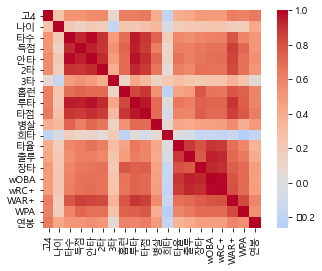

In [79]:
# 연봉과 각 특성의 상관관계
# 색이 진할수록 (1.0에 가까울수록) 상관관계 높음
plt.rcParams['font.family'] = 'Malgun Gothic'


correlations = df_merge[Answer].corr(method = 'pearson')
sns.heatmap(correlations, cmap="coolwarm", square=True, center=0)

## Scaling

In [80]:
# 변수들의 단위 차이로 인해 숫자의 스케일이 크게 달라지는 경우 스케일링(scaling)으로 해결
# https://mkjjo.github.io/python/2019/01/10/scaler.html 참고
# Standard Scaling 사용

df1 = df_merge

def standard_scaling(df1, scale_columns):
    for col in scale_columns:
        series_mean= df1[col].mean()
        series_std = df1[col].std()
        df1[col]=df1[col].apply(lambda x: (x-series_mean)/series_std)
    return df1

In [81]:
# scaling 적용할 특성 
scale_columns = ['시즌', '나이', 'G', '타수', '득점', '안타', '2타', '3타', '홈런', '루타', '타점', '도루',
       '도실', '볼넷', '사구', '고4', '삼진', '병살', '희타', '희비', '타율', '출루', '장타', 'OPS',
       'wOBA', 'wRC+', 'WAR+', 'WPA']

In [82]:
batter_df=standard_scaling(df1, scale_columns)
batter_df

<ipython-input-80-baaf19c907ee>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[col]=df1[col].apply(lambda x: (x-series_mean)/series_std)


,ID,이름,시즌,팀,생일,나이,포지션,포지션여부,G,타수,...,타율,출루,장타,OPS,wOBA,wRC+,WAR+,WPA,연봉,억대연봉
0,0,최형우,-1.427925,삼,1983-12-16,0.889908,LF,True,1.205253,1.504644,...,2.216529,2.363817,2.560043,2.638485,2.586229,2.320507,3.683734,3.016723,150000,1
1,2,김재환,-0.725554,두,1988-09-22,-0.014090,LF,True,1.365201,1.654790,...,1.486960,1.715989,2.085431,2.066753,1.906675,2.142395,3.518777,4.208907,47000,1
2,3,김하성,0.679188,키,1995-10-17,-1.144089,SS,True,1.231911,1.630766,...,0.818188,0.975613,0.978004,1.032191,1.176155,1.491902,3.353819,2.417575,32000,1
3,4,박건우,-0.725554,두,1990-09-08,-0.466090,CF,True,1.018646,1.288434,...,2.013871,1.623442,1.877789,1.889788,1.787753,1.959121,3.262808,1.341552,37000,1
4,2,김재환,-0.023183,두,1988-09-22,0.211909,LF,True,1.231911,1.552691,...,1.365365,1.271763,2.619370,2.270943,1.872698,2.088188,3.222991,3.200136,47000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818,363,정보근,1.381559,롯,1999-08-31,-1.822088,C,True,-0.207627,-0.813606,...,-2.363543,-2.170985,-2.245400,-2.336943,-2.391501,-2.369760,-1.395817,-1.421868,2900,0
819,419,김연훈,-1.427925,k,1984-12-23,0.663909,1B,True,0.272219,-0.615414,...,-1.005734,-1.708250,-0.959994,-1.281962,-1.542059,-1.773474,-1.407194,-0.565942,4100,0
820,174,이해창,-1.427925,k,1987-05-11,-0.014090,C,True,-0.127653,-0.225035,...,-1.289455,-1.782287,-0.663361,-1.111803,-1.389159,-1.621176,-1.412882,-1.800922,4500,0
821,420,조인성,-1.427925,한,1975-05-25,2.697905,C,True,-0.447550,-0.789583,...,-1.998758,-2.781795,-1.424717,-2.003433,-2.374512,-2.589173,-1.498205,-1.495234,40000,1


## One-hot-encoding (미사용)

In [ ]:
# 원 핫 인코딩을 통해 팀들의 feature 단위 맞추기
#team_encoding = pd.get_dummies(batter_df['팀'])
#batter_df = batter_df.drop('팀',axis=1)
#batter_df = batter_df.join(team_encoding)
#team_encoding

## 회귀분석

In [83]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

In [84]:
batter_df = batter_df.rename(columns={'연봉':'y'})
batter_df = batter_df.rename(columns={'연봉':'y'})
x = batter_df[batter_df.columns.difference(['이름','y'])]
y = batter_df['y']

# 회귀분석 위해 수치형 데이터를 제외한 category 타입 column 제거 
x = x.drop('생일', axis=1) 
x = x.drop('포지션', axis=1)
x = x.drop('억대연봉', axis=1)
x = x.drop('포지션여부', axis=1)
x = x.drop('ID', axis=1)
x = x.drop('팀', axis=1)
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2, random_state = 1357)

In [85]:
# Linear regression 사용하여 회귀분석 계수 학습 및 출력
lr  = linear_model.LinearRegression()
model = lr.fit(x_train, y_train)

In [86]:
# 회귀분석 계수 출력
print(lr.coef_)

[ 1.93666858e+15  6.71345022e+14 -5.66204823e+03  1.43626469e+05
  5.48617222e+03  8.30120999e+02  1.25298390e+04 -3.66794836e+02
  1.29280021e+04  7.50114752e+03  1.42815501e+03  1.66004954e+03
 -6.73302548e+03 -1.57774343e+16  4.24733688e+03  6.68993805e+03
  3.05819372e+03 -9.12555299e+03  1.46243293e+02  9.78155110e+15
 -1.07815733e+05 -6.35949019e+04  2.62022716e+04  4.98627442e+03
  2.67557993e+03  4.94144694e+15 -7.66545964e+02 -8.81613802e+02]


In [87]:
# 위 출력된 계수와 열 순서대로 매칭하여 각 특성의 계수 확인
x.columns

Index(['2타', '3타', 'G', 'OPS', 'WAR+', 'WPA', 'wOBA', 'wRC+', '고4', '나이', '도루',
       '도실', '득점', '루타', '병살', '볼넷', '사구', '삼진', '시즌', '안타', '장타', '출루', '타수',
       '타율', '타점', '홈런', '희비', '희타'],
      dtype='object')

## 예측모델 평가

In [88]:
import statsmodels.api as sm

In [89]:
x_train = sm.add_constant(x_train)
model = sm.OLS(y_train, x_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     34.93
Date:                Thu, 16 Dec 2021   Prob (F-statistic):          2.56e-106
Time:                        18:09:58   Log-Likelihood:                -7522.2
No. Observations:                 654   AIC:                         1.510e+04
Df Residuals:                     626   BIC:                         1.523e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.661e+04    962.445     27.646      0.000    2.47e+04    2.85e+04
2타         -2704.4805   3054.046     -0.886      0.376   -8701.896    3292.935
3타           917.4159   1589.846      0.577      0.564   -2204.661    4039.493
G          -5662.4257   2648.498     -2.138      0.033   -1.09e+04    -461.408
OPS         1.436e+05   2.97e+05      0.484      0.628   -4.39e+05    7.26e+05
WAR+        5487.9026   4248.575      1.292      0.197   -2855.282    1.38e+04
WPA          831.3218   2519.480      0.330      0.742   -4116.333    5778.977
wOBA        1.254e+04    1.7e+04      0.740      0.460   -2.08e+04    4.58e+04
wRC+        -375.2093      1e+04     -0.037      0.970      -2e+04    1.93e+04
고4          1.293e+04   1440.389      8.974      0.000    1.01e+04    1.58e+04
나이          7500.2043   1106.130      6.781      0.000    5328.030    9672.379
도루          1427.3384   1861.549      0.767      0.444   -2228.299    5082.975
도실          1660.2087   1666.040      0.996      0.319   -1611.496    4931.913
득점         -6739.4289   4582.809     -1.471      0.142   -1.57e+04    2260.111
루타         -5968.1677   6273.762     -0.951      0.342   -1.83e+04    6352.000
병살          4247.6758   1787.273      2.377      0.018     737.899    7757.453
볼넷          6686.7040   3541.210      1.888      0.059    -267.385    1.36e+04
사구          3058.7134   1499.168      2.040      0.042     114.705    6002.721
삼진         -9125.0656   2424.738     -3.763      0.000   -1.39e+04   -4363.460
시즌           146.3720   1383.280      0.106      0.916   -2570.059    2862.803
안타         -1.623e+04   1.06e+04     -1.533      0.126    -3.7e+04    4565.911
장타         -1.078e+05   2.04e+05     -0.529      0.597   -5.08e+05    2.92e+05
출루          -6.36e+04   1.09e+05     -0.585      0.559   -2.77e+05     1.5e+05
타수           2.62e+04   1.43e+04      1.830      0.068   -1922.295    5.43e+04
타율          4981.3298   3884.551      1.282      0.200   -2646.999    1.26e+04
타점          2673.9747   5339.589      0.501      0.617   -7811.701    1.32e+04
홈런          1.401e+04   4121.091      3.400      0.001    5917.686    2.21e+04
희비          -764.9907   1599.902     -0.478      0.633   -3906.816    2376.835
희타          -882.7706   1488.918     -0.593      0.553   -3806.649    2041.108
==============================================================================
Omnibus:                      324.354   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3305.047
Skew:                           1.967   Prob(JB):                         0.00
Kurtosis:                      13.287   Cond. No.                     2.25e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is co

In [90]:
# 회귀 계수 리스트로 반환
coefs = model.params.tolist()
coefs_series = pd.Series(coefs)

In [91]:
# 변수명 리스트로 반환
x_labels = model.params.index.tolist()

[Text(0, 0, 'const'),
 Text(1, 0, '2타'),
 Text(2, 0, '3타'),
 Text(3, 0, 'G'),
 Text(4, 0, 'OPS'),
 Text(5, 0, 'WAR+'),
 Text(6, 0, 'WPA'),
 Text(7, 0, 'wOBA'),
 Text(8, 0, 'wRC+'),
 Text(9, 0, '고4'),
 Text(10, 0, '나이'),
 Text(11, 0, '도루'),
 Text(12, 0, '도실'),
 Text(13, 0, '득점'),
 Text(14, 0, '루타'),
 Text(15, 0, '병살'),
 Text(16, 0, '볼넷'),
 Text(17, 0, '사구'),
 Text(18, 0, '삼진'),
 Text(19, 0, '시즌'),
 Text(20, 0, '안타'),
 Text(21, 0, '장타'),
 Text(22, 0, '출루'),
 Text(23, 0, '타수'),
 Text(24, 0, '타율'),
 Text(25, 0, '타점'),
 Text(26, 0, '홈런'),
 Text(27, 0, '희비'),
 Text(28, 0, '희타')]

C:\Users\Administrator\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Administrator\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


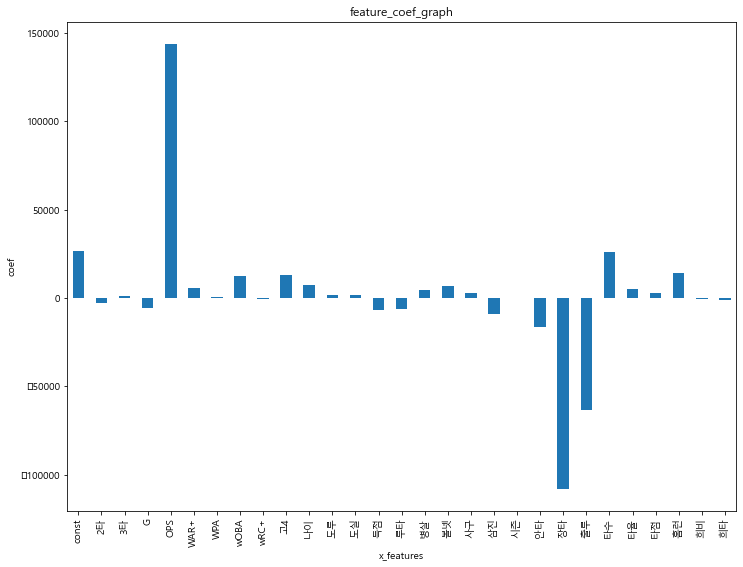

In [92]:
# 회귀 계수 출력 
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams["figure.figsize"] = (12, 9)
ax = coefs_series.plot(kind='bar')
ax.set_title('feature_coef_graph')
ax.set_xlabel('x_features')
ax.set_ylabel('coef')
ax.set_xticklabels(x_labels)

## Auto ML

In [93]:
# 불필요 열 제거
ml = ml.drop('생일', axis=1) 
ml = ml.drop('포지션', axis=1)
ml = ml.drop('억대연봉', axis=1)
ml = ml.drop('포지션여부', axis=1)
ml = ml.drop('ID', axis=1)
ml = ml.drop('팀', axis=1)

In [94]:
ml = ml.drop('이름', axis=1)

In [95]:
# 각 특성명 영문으로 변경
ml = ml.rename(columns={'2타':'DOUBLE'})
ml = ml.rename(columns={'3타':'TRIPLE'})
ml = ml.rename(columns={'고4':'GO4'})
ml = ml.rename(columns={'나이':'Age'})
ml = ml.rename(columns={'도루':'SB'})
ml = ml.rename(columns={'도실':'Y'})
ml = ml.rename(columns={'득점':'Runs Scored'})
ml = ml.rename(columns={'루타':'SINGLE'})
ml = ml.rename(columns={'병살':'GIDP'})
ml = ml.rename(columns={'볼넷':'BOB'})
ml = ml.rename(columns={'사구':'DDB'})
ml = ml.rename(columns={'삼진':'3S'})
ml = ml.rename(columns={'시즌':'SS'})
ml = ml.rename(columns={'안타':'IH'})
ml = ml.rename(columns={'장타':'EBH'})
ml = ml.rename(columns={'출루':'OB'})
ml = ml.rename(columns={'타수':'AB'})
ml = ml.rename(columns={'타율':'AVG'})
ml = ml.rename(columns={'타점':'RBI'})
ml = ml.rename(columns={'홈런':'HR'})
ml = ml.rename(columns={'희비':'SF'})
ml = ml.rename(columns={'희타':'SH'})

In [96]:
ml = ml.rename(columns={'연봉':'y'})

In [97]:
y = ml.y
x = ml.drop('y', axis=1)

In [98]:
ml1 = pd.concat([x, y], axis =1)

In [99]:
from sklearn.model_selection import train_test_split, GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(ml1, y, test_size=0.3, random_state=1357) 
# train test 7:3 비율로 분할

### - 15개의 기본 모델을 학습하고 모델들의 성능을 비교& 분석

In [100]:
from pycaret.regression import*
clf = setup(data = ml1,    # 데이터셋
            target = 'y', # 연봉
            ignore_low_variance = True,
            normalize = True,
            feature_selection = True,
            train_size = 0.70, 
            session_id = 1357)




#ignore_low_variance : True로 설정하면 범주형 변수 중에 변수중요도가 낮은 변수를 삭제
#session_id : random_state와 같은 파라미터
#normalize : True로 설정하면 정규화

,Description,Value
0,session_id,1357
1,Target,y
2,Original Data,"(818, 29)"
3,Missing Values,False
4,Numeric Features,28
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(572, 27)"


### - MAE기준 성능 상위 3개 모델 선발

In [101]:
best_3 = compare_models(sort = 'MAE', n_select = 3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,13534.7542,657846483.9244,25215.3352,0.5454,0.6692,0.7308,2.4250
et,Extra Trees Regressor,13672.4095,624883512.2470,24667.8360,0.5663,0.6627,0.7678,0.1570
rf,Random Forest Regressor,13693.2370,655027724.7320,25235.3909,0.5503,0.6598,0.7410,0.2410
huber,Huber Regressor,13861.0806,717544038.0239,26294.8773,0.5189,0.8291,0.7733,0.0250
par,Passive Aggressive Regressor,13920.2077,741056740.4491,26726.1278,0.5049,0.7440,0.7229,0.0140
gbr,Gradient Boosting Regressor,14068.9387,700780123.7272,26098.7387,0.5082,0.6760,0.7359,0.0810
xgboost,Extreme Gradient Boosting,14462.1183,709827897.6000,26305.2357,0.5098,0.6835,0.7277,0.3300
knn,K Neighbors Regressor,14582.7152,742027475.2000,26848.7039,0.4730,0.7103,0.7828,0.0120
lightgbm,Light Gradient Boosting Machine,15229.2686,758470866.2359,27242.8064,0.4613,0.7892,0.8047,0.1670
en,Elastic Net,15315.2839,692379126.4000,25970.2594,0.5274,0.9068,1.0515,0.0090


### - Score 최적화를 위해 성능 상위 3개 모델을 혼합한 voting regressor 사용

In [102]:
blended = blend_models(estimator_list = best_3, fold = 5, optimize = 'MAE')


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,13997.3661,585362327.6881,24194.2623,0.5479,0.6502,0.7454
1,12615.9639,465923119.1958,21585.2524,0.6385,0.6576,0.7522
2,14503.5518,802504336.2876,28328.5075,0.3983,0.7065,0.8620
3,13883.9318,699464695.4767,26447.3949,0.6323,0.6186,0.6775
4,13057.5177,697396231.7796,26408.2607,0.6070,0.6483,0.6431
Mean,13611.6662,650130142.0856,25392.7355,0.5648,0.6563,0.7360
SD,680.7138,114902544.3719,2310.6545,0.0892,0.0285,0.0752


### - Train dataset을 통해 MAE확인

In [103]:
pred_holdout = predict_model(blended)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,11448.0516,432334231.0235,20792.6485,0.5342,0.6414,0.7321


### - 모델 튜닝으로 성능향상

In [104]:
tunes_model = tune_model(blended, fold = 3)
tunes_model

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,13525.6500,515091547.9339,22695.6284,0.5279,0.6545,0.7544
1,13126.8683,647388184.6527,25443.8241,0.5569,0.6524,0.7357
2,14111.5371,845757260.1134,29081.9061,0.5767,0.6264,0.6303
Mean,13588.0185,669412330.9000,25740.4528,0.5538,0.6444,0.7068
SD,404.4012,135889049.2675,2615.6105,0.0200,0.0128,0.0546


VotingRegressor(estimators=[('catboost',
                             <catboost.core.CatBoostRegressor object at 0x000002C342C6F430>),
                            ('et',
                             ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                                 criterion='mse',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fract...
                                                   cr

### - final_model (성능 튜닝을 통해 MAE값 13611 -> 2110감소)

In [105]:
final_model = finalize_model(tunes_model)

In [106]:
pred_holdout = predict_model(final_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,2110.3870,8977058.0780,2996.1739,0.9903,0.2276,0.1799


## - 예측 결과

In [107]:
predictions = predict_model(final_model, data = ml1)

In [108]:
predictions

,SS,Age,G,AB,Runs Scored,IH,DOUBLE,TRIPLE,HR,SINGLE,...,AVG,OB,EBH,OPS,wOBA,wRC+,WAR+,WPA,y,Label
0,-1.427925,0.889908,1.205253,1.504644,1.959223,2.211040,3.071928,0.451572,2.577267,2.574265,...,2.216529,2.363817,2.560043,2.638485,2.586229,2.320507,3.683734,3.016723,150000,148499.555020
1,-0.725554,-0.014090,1.365201,1.654790,2.328411,2.024625,1.942098,0.451572,3.020074,2.458693,...,1.486960,1.715989,2.085431,2.066753,1.906675,2.142395,3.518777,4.208907,47000,51630.534693
2,0.679188,-1.144089,1.231911,1.630766,2.395536,1.670438,2.318708,0.451572,1.248846,1.730592,...,0.818188,0.975613,0.978004,1.032191,1.176155,1.491902,3.353819,2.417575,32000,33916.690640
3,-0.725554,-0.466090,1.018646,1.288434,1.690723,1.875494,2.507013,0.451572,1.359547,1.915507,...,2.013871,1.623442,1.877789,1.889788,1.787753,1.959121,3.262808,1.341552,37000,38258.787759
4,-0.023183,0.211909,1.231911,1.552691,2.127035,1.856852,2.130403,-0.091643,4.016390,2.666722,...,1.365365,1.271763,2.619370,2.270943,1.872698,2.088188,3.222991,3.200136,47000,48446.162410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818,1.381559,-1.822088,-0.207627,-0.813606,-1.061405,-1.051214,-1.070784,-0.634857,-0.854488,-1.077797,...,-2.363543,-2.170985,-2.245400,-2.336943,-2.391501,-2.369760,-1.395817,-1.421868,2900,3351.940529
819,-1.427925,0.663909,0.272219,-0.615414,-0.927155,-0.752950,-0.317563,-0.634857,-0.743786,-0.765753,...,-1.005734,-1.708250,-0.959994,-1.281962,-1.542059,-1.773474,-1.407194,-0.565942,4100,7974.747712
820,-1.427925,-0.014090,-0.127653,-0.225035,-0.826467,-0.547894,-0.317563,-0.634857,-0.190277,-0.465267,...,-1.289455,-1.782287,-0.663361,-1.111803,-1.389159,-1.621176,-1.412882,-1.800922,4500,4896.214608
821,-1.427925,2.697905,-0.447550,-0.789583,-1.027842,-0.995289,-1.070784,-0.634857,-0.522382,-0.939111,...,-1.998758,-2.781795,-1.424717,-2.003433,-2.374512,-2.589173,-1.498205,-1.495234,40000,41220.814638


In [109]:
predictions = predictions.rename(columns={'y':'actual salary'})

In [110]:
predictions = predictions.rename(columns={'Label':'prediction salary'})

In [111]:
predictions

,SS,Age,G,AB,Runs Scored,IH,DOUBLE,TRIPLE,HR,SINGLE,...,AVG,OB,EBH,OPS,wOBA,wRC+,WAR+,WPA,actual salary,prediction salary
0,-1.427925,0.889908,1.205253,1.504644,1.959223,2.211040,3.071928,0.451572,2.577267,2.574265,...,2.216529,2.363817,2.560043,2.638485,2.586229,2.320507,3.683734,3.016723,150000,148499.555020
1,-0.725554,-0.014090,1.365201,1.654790,2.328411,2.024625,1.942098,0.451572,3.020074,2.458693,...,1.486960,1.715989,2.085431,2.066753,1.906675,2.142395,3.518777,4.208907,47000,51630.534693
2,0.679188,-1.144089,1.231911,1.630766,2.395536,1.670438,2.318708,0.451572,1.248846,1.730592,...,0.818188,0.975613,0.978004,1.032191,1.176155,1.491902,3.353819,2.417575,32000,33916.690640
3,-0.725554,-0.466090,1.018646,1.288434,1.690723,1.875494,2.507013,0.451572,1.359547,1.915507,...,2.013871,1.623442,1.877789,1.889788,1.787753,1.959121,3.262808,1.341552,37000,38258.787759
4,-0.023183,0.211909,1.231911,1.552691,2.127035,1.856852,2.130403,-0.091643,4.016390,2.666722,...,1.365365,1.271763,2.619370,2.270943,1.872698,2.088188,3.222991,3.200136,47000,48446.162410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818,1.381559,-1.822088,-0.207627,-0.813606,-1.061405,-1.051214,-1.070784,-0.634857,-0.854488,-1.077797,...,-2.363543,-2.170985,-2.245400,-2.336943,-2.391501,-2.369760,-1.395817,-1.421868,2900,3351.940529
819,-1.427925,0.663909,0.272219,-0.615414,-0.927155,-0.752950,-0.317563,-0.634857,-0.743786,-0.765753,...,-1.005734,-1.708250,-0.959994,-1.281962,-1.542059,-1.773474,-1.407194,-0.565942,4100,7974.747712
820,-1.427925,-0.014090,-0.127653,-0.225035,-0.826467,-0.547894,-0.317563,-0.634857,-0.190277,-0.465267,...,-1.289455,-1.782287,-0.663361,-1.111803,-1.389159,-1.621176,-1.412882,-1.800922,4500,4896.214608
821,-1.427925,2.697905,-0.447550,-0.789583,-1.027842,-0.995289,-1.070784,-0.634857,-0.522382,-0.939111,...,-1.998758,-2.781795,-1.424717,-2.003433,-2.374512,-2.589173,-1.498205,-1.495234,40000,41220.814638


### - 실제 연봉과 예측 연봉 예측 결과

In [112]:
predictions['prediction salary'] = predictions['prediction salary'].astype(int)
predictions[['actual salary','prediction salary']]

,actual salary,prediction salary
0,150000,148499
1,47000,51630
2,32000,33916
3,37000,38258
4,47000,48446
...,...,...
818,2900,3351
819,4100,7974
820,4500,4896
821,40000,41220


## - ML 모델 평가

In [113]:
evaluate_model(final_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

## Catboost Regressor
### - MAE 기준으로 가장 성능이 좋게 나온 단일 모델 

In [114]:
catboost = create_model('catboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,11833.8541,471733232.9477,21719.4206,0.4768,0.6632,0.7659
1,14598.7104,685891759.4257,26189.5353,0.5765,0.6075,0.6302
2,11899.1415,414697481.4092,20364.1224,0.5451,0.6495,0.6942
3,12975.5722,504391977.4194,22458.6727,0.6976,0.6522,0.7387
4,17307.5191,1142782715.0660,33805.0694,0.3732,0.7169,0.8683
5,13605.7816,585706712.0122,24201.3783,0.2688,0.7494,0.9680
6,11210.2989,308637692.9142,17568.0873,0.7703,0.6756,0.7017
7,14481.4121,878824362.9505,29644.9720,0.6421,0.5852,0.6095
8,15233.4634,893916367.3795,29898.4342,0.5232,0.6175,0.5029
9,12201.7889,691882537.7195,26303.6602,0.5807,0.7754,0.8283


In [115]:
tuned_cat = tune_model(catboost, optimize='MAE') # 성능튜닝

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,12080.9399,474187111.9784,21775.8378,0.4741,0.7569,0.8605
1,14916.3491,741955813.2277,27238.8659,0.5419,0.6241,0.6097
2,13555.3783,482543012.4763,21966.8617,0.4707,0.6991,0.7515
3,12978.8110,523571331.9573,22881.6811,0.6861,0.6905,0.7768
4,16001.6277,1001927492.8014,31653.2383,0.4504,0.7116,0.8204
5,11423.6097,450355265.0867,21221.5755,0.4378,0.6905,0.8252
6,12312.7215,433495307.9684,20820.5501,0.6773,0.7487,0.7822
7,13910.9798,902513410.3145,30041.8610,0.6324,0.5673,0.5518
8,16696.9294,1214088231.4070,34843.7689,0.3525,0.6703,0.5739
9,12885.8423,701660545.3389,26488.8759,0.5748,0.7672,0.8857


In [116]:
final_model = finalize_model(tuned_cat) # 최종모델

In [117]:
pred_holdout = predict_model(final_model) 

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,3195.0425,21066419.4228,4589.8169,0.9773,0.3190,0.2706


In [118]:
predictions = predict_model(final_model, data = ml1) #예측
predictions

,SS,Age,G,AB,Runs Scored,IH,DOUBLE,TRIPLE,HR,SINGLE,...,AVG,OB,EBH,OPS,wOBA,wRC+,WAR+,WPA,y,Label
0,-1.427925,0.889908,1.205253,1.504644,1.959223,2.211040,3.071928,0.451572,2.577267,2.574265,...,2.216529,2.363817,2.560043,2.638485,2.586229,2.320507,3.683734,3.016723,150000,148891.771990
1,-0.725554,-0.014090,1.365201,1.654790,2.328411,2.024625,1.942098,0.451572,3.020074,2.458693,...,1.486960,1.715989,2.085431,2.066753,1.906675,2.142395,3.518777,4.208907,47000,52381.659011
2,0.679188,-1.144089,1.231911,1.630766,2.395536,1.670438,2.318708,0.451572,1.248846,1.730592,...,0.818188,0.975613,0.978004,1.032191,1.176155,1.491902,3.353819,2.417575,32000,32087.951389
3,-0.725554,-0.466090,1.018646,1.288434,1.690723,1.875494,2.507013,0.451572,1.359547,1.915507,...,2.013871,1.623442,1.877789,1.889788,1.787753,1.959121,3.262808,1.341552,37000,37746.959448
4,-0.023183,0.211909,1.231911,1.552691,2.127035,1.856852,2.130403,-0.091643,4.016390,2.666722,...,1.365365,1.271763,2.619370,2.270943,1.872698,2.088188,3.222991,3.200136,47000,48356.185477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818,1.381559,-1.822088,-0.207627,-0.813606,-1.061405,-1.051214,-1.070784,-0.634857,-0.854488,-1.077797,...,-2.363543,-2.170985,-2.245400,-2.336943,-2.391501,-2.369760,-1.395817,-1.421868,2900,4659.224433
819,-1.427925,0.663909,0.272219,-0.615414,-0.927155,-0.752950,-0.317563,-0.634857,-0.743786,-0.765753,...,-1.005734,-1.708250,-0.959994,-1.281962,-1.542059,-1.773474,-1.407194,-0.565942,4100,11822.297111
820,-1.427925,-0.014090,-0.127653,-0.225035,-0.826467,-0.547894,-0.317563,-0.634857,-0.190277,-0.465267,...,-1.289455,-1.782287,-0.663361,-1.111803,-1.389159,-1.621176,-1.412882,-1.800922,4500,6659.066615
821,-1.427925,2.697905,-0.447550,-0.789583,-1.027842,-0.995289,-1.070784,-0.634857,-0.522382,-0.939111,...,-1.998758,-2.781795,-1.424717,-2.003433,-2.374512,-2.589173,-1.498205,-1.495234,40000,37949.816406


In [119]:
predictions = predictions.rename(columns={'y':'actual salary'})
predictions = predictions.rename(columns={'Label':'prediction salary'})
predictions['prediction salary'] = predictions['prediction salary'].astype(int)
predictions[['actual salary','prediction salary']] # catboost 모델 실제연봉, 예측연봉

,actual salary,prediction salary
0,150000,148891
1,47000,52381
2,32000,32087
3,37000,37746
4,47000,48356
...,...,...
818,2900,4659
819,4100,11822
820,4500,6659
821,40000,37949


In [120]:
evaluate_model(final_model) # catboost 모델 평가

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

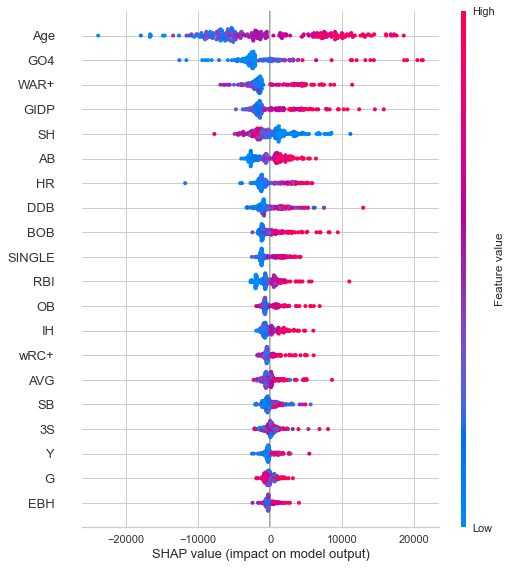

In [122]:
interpret_model(final_model)

### 2타:DOUBLE
### 3타:TRIPLE
### 고4:GO4
### 나이:Age
### 도루:SB
### 도실:Y
### 득점:Runs Scored
### 루타:SINGLE
### 병살:GIDP
### 볼넷:BOB
### 사구:DDB
### 삼진:3S
### 시즌:SS
### 안타:IH
### 장타:EBH
### 출루:OB
### 타수:AB
### 타율:AVG
### 타점:RBI
### 홈런:HR
### 희비:SF
### 희타:SH

### 특성 중요도 (catboost 모델)
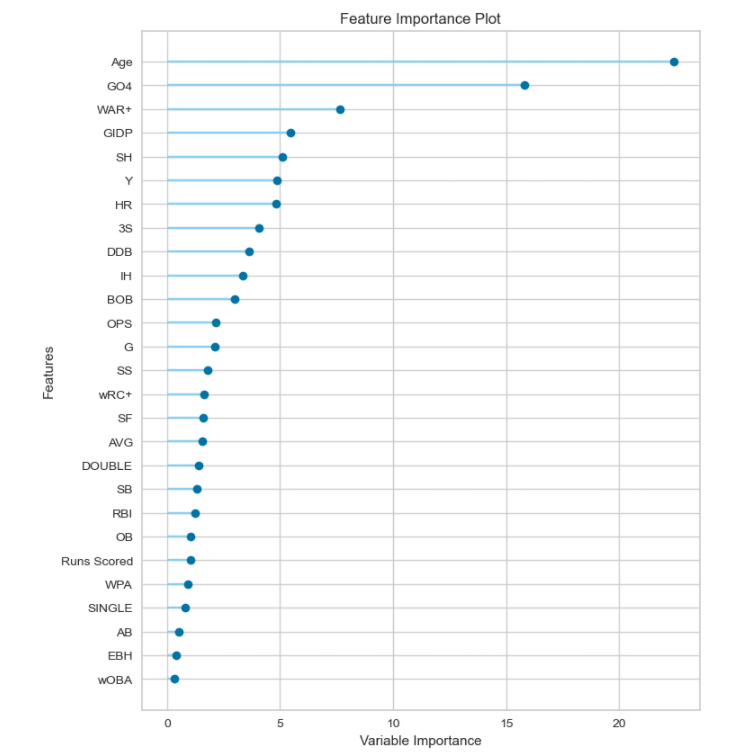

## Prediction error
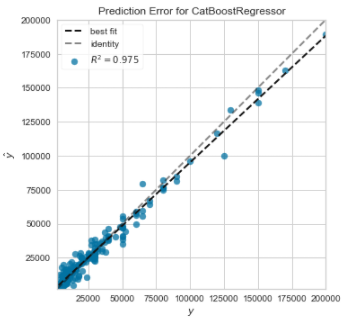

# validation curve
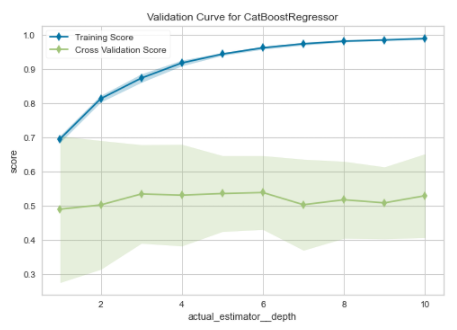

## Learning Curve
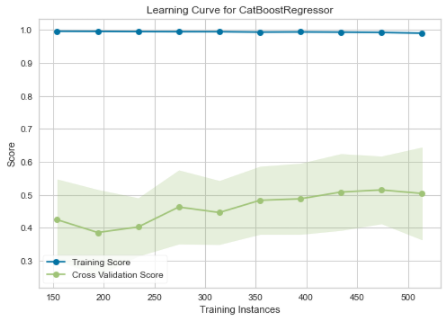